In [1]:
### import libraries
import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Sequential

from keras.applications.densenet import DenseNet121
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Conv2D, Flatten
from keras import backend as K
from keras.models import load_model
from keras.utils.vis_utils import plot_model

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib
# matplotlib.use("Agg") # set the matplotlib backend so figures can be saved in the background
 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import datetime
import tensorflow as tf

import json

In [2]:
def read_config(p):
    '''read from configuration file'''
    with open(p) as f:
        d = json.load(f)
    
    #fix trailing slash
    if(d['df'][-1] != '/'):
        d['df'] += '/'
    
    print("path: ", d['df'])
    print("train labels: ", d['train_labels'])
    print("test_labels: ", d['test_labels'])
    print("all_labels: ", d['all_labels']),
    print("processing labels: ", d['processing_labels'])
    print("batch size: ", d['batch_size'])
    return d['df'], d['train_labels'], d['test_labels'], d['all_labels'], d['processing_labels'], d['batch_size']

In [17]:
[df_path, train_labels, test_labels, all_labels, processing_labels, batch_size] = read_config('config.json')
x_col = processing_labels['x_col']
y_col = processing_labels['y_col']
number_of_classes = len(y_col)

# import train data info from valid.csv
dtrain=pd.read_csv(df_path + train_labels, nrows=150000)
dtrain = dtrain.fillna(0)

# import valid data info from valid.csv
dtest = pd.read_csv(df_path + test_labels)
dtest = dtest.fillna(0)

#add dnew to dtrain to re-split since valid data in data set is very small
# dtrain = dtrain.append(dtest)

#pre-process data: remove Lateral images
dtrain = dtrain[~dtrain[dtrain.columns[3]].str.contains("Lateral")]

#pre-process data: drop selected features - only images as inputs
#drop all features that are not included in processing_features
to_drop = list(set(all_labels) - set(y_col))
to_drop.remove(x_col)
print('dropping columns....\n', to_drop)
dtrain = dtrain.drop(to_drop, axis=1)

#uncertain examples make them positive
dtrain = dtrain.replace(-1,1)

dtrain.drop(dtrain.loc[(dtrain['Pneumonia'] == 0) & (dtrain['Pneumothorax'] == 0)].index, inplace=True)
print(dtrain.shape)

path:  CheXpert-v1.0-small/
train labels:  train.csv
test_labels:  valid.csv
all_labels:  ['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Edema', 'Pneumonia', 'Lung Lesion', 'No Finding', 'Consolidation', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
processing labels:  {'x_col': 'Path', 'y_col': ['Pneumonia', 'Pneumothorax']}
batch size:  32
dropping columns....
 ['Pleural Effusion', 'No Finding', 'Enlarged Cardiomediastinum', 'AP/PA', 'Atelectasis', 'Consolidation', 'Pleural Other', 'Lung Opacity', 'Sex', 'Lung Lesion', 'Age', 'Support Devices', 'Fracture', 'Frontal/Lateral', 'Edema', 'Cardiomegaly']
(25950, 3)


In [18]:
count = 0
for index, row in dtrain.iterrows():
#     print(row['Pneumonia'], row['Lung Lesion'])
    if row['Pneumonia'] == 0.0 and row['Pneumothorax'] == 0.0:
        count += 1
print(count)

dtrain.head()


0


,Path,Pneumonia,Pneumothorax
9,CheXpert-v1.0-small/train/patient00005/study2/...,0.0,1.0
10,CheXpert-v1.0-small/train/patient00005/study2/...,0.0,1.0
12,CheXpert-v1.0-small/train/patient00007/study1/...,0.0,1.0
22,CheXpert-v1.0-small/train/patient00011/study1/...,0.0,1.0
23,CheXpert-v1.0-small/train/patient00011/study5/...,0.0,1.0


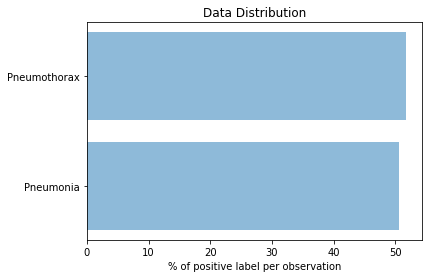

<Figure size 432x288 with 0 Axes>

In [19]:
%matplotlib inline
features_size=[]
features_data =[]
features_name=[]
for feature in list(dtrain.columns[1:number_of_classes+1]):
    data_feature = dtrain.loc[dtrain[feature] == 1]
    features_size.append(data_feature.shape[0])
    features_data.append(data_feature)
    features_name.append(feature)

objects = list(dtrain.columns[1:number_of_classes+1])
y_pos = np.arange(len(objects))
performance = np.array(features_size)/dtrain.shape[0]*100
# print(features_data)
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('% of positive label per observation')
plt.title('Data Distribution')
plt.show()
plt.savefig('DataDistribute.png', bbox_inches='tight')

* Pixel Normalization: scale pixel values to the range 0-1.
* Pixel Centering: scale pixel values to have a zero mean.
* Pixel Standardization: scale pixel values to have a zero mean and unit variance.

In [1]:
### split data into train/valid/test
#random suffle on entire dataset
dtrain = dtrain.sample(frac=1)
#Use 10% as validation set
dvalid_size = round(0.2*dtrain.shape[0])
#Use 10% as test set
dtest_size = dvalid_size

dtr = dtrain[0:dtrain.shape[0]-dvalid_size-dtest_size+1]
dv = dtrain[dtrain.shape[0]-dvalid_size-dtest_size:dtrain.shape[0]-dvalid_size+1]
dte = dtrain[dtrain.shape[0]-dvalid_size:dtrain.shape[0]+1]

print("Train set -\t", dtr.shape)
print("Valid set -\t", dv.shape)
print("Test set -\t", dte.shape)

NameError: name 'dtrain' is not defined

In [22]:
### data generation for Keras 
train_datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)
valid_datagen=ImageDataGenerator(rescale=1./255.)

# target_size = (224,224)
#target_size = (299,299)
target_size = (100,100)
train_generator=train_datagen.flow_from_dataframe(dataframe=dtr, directory=None , 
                                                  x_col="Path", y_col=list(dtr.columns[1:number_of_classes+1]), 
                                                  class_mode="other", 
                                                  target_size=target_size, 
                                                  batch_size=batch_size)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=dv, directory=None , 
                                                  x_col="Path", y_col=list(dv.columns[1:number_of_classes+1]), 
                                                  class_mode="other", 
                                                  target_size=target_size, 
                                                  batch_size=batch_size)
test_generator=test_datagen.flow_from_dataframe(dataframe=dte, directory=None , 
                                                x_col="Path", y_col=list(dte.columns[1:number_of_classes+1]), 
                                                class_mode="other", 
                                                target_size=target_size, 
                                                shuffle = False, batch_size=1)



Found 20761 validated image filenames.
Found 2596 validated image filenames.
Found 2595 validated image filenames.


In [23]:
 def global_average_pooling(x):
        return K.mean(x, axis = (2, 3))
    
def global_average_pooling_shape(input_shape):
    return input_shape[0:2]

In [24]:
# ### model architecture design/selection

#create model

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
# model.add(Lambda(global_average_pooling, output_shape=global_average_pooling_shape))
model.add(GlobalAveragePooling2D())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(number_of_classes, activation='sigmoid'))




# model = Sequential()
# #add model layers
# model.add(Conv2D(256, 3, input_shape = (50, 50, 3), activation = 'relu'))
# # model.add(Conv2D(256, 3, activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(BatchNormalization())
# # model.add(Dropout(0.5))
# model.add(Conv2D(128, 3, activation= 'relu'))
# model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Dropout(0.2))

# # model.add(BatchNormalization())
# model.add(Conv2D(64, 3, activation= 'relu'))
# # model.add(BatchNormalization())
# model.add(Conv2D(32, 3, activation= 'relu'))
# # model.add(BatchNormalization())

# model.add(Flatten())
# # model.add(Dense(128, activation= 'relu'))
# # model.add(Dropout(0.3))
# model.add(Dense(24, activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(Dense(12, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(number_of_classes, activation='sigmoid'))


adam = keras.optimizers.Adam(learning_rate=0.0001)#beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])
plot_model(model, to_file='simple_base_model_plot.png', show_shapes=True, show_layer_names=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 96, 96, 16)        1216      
_________________________________________________________________
batch_normalization_4 (Batch (None, 96, 96, 16)        64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 44, 44, 32)        12832     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 22, 22, 32)       

In [25]:
num_epochs = 10
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

#Tensorboard
log_dir = "logs/simple_model/"# + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_h = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=num_epochs,
                    workers=8,
                    callbacks=[tensorboard_callback])

# save model
model.save("model_DenseNet121_TF_Simple_cam.h5")

Epoch 1/10
648/648 [==============================] - 396s 605ms/step - loss: 0.7810 - accuracy: 0.5275 - val_loss: 0.7708 - val_accuracy: 0.5251
Epoch 2/10
648/648 [==============================] - 365s 563ms/step - loss: 0.7020 - accuracy: 0.5698 - val_loss: 0.6864 - val_accuracy: 0.5725
Epoch 3/10
648/648 [==============================] - 383s 592ms/step - loss: 0.6841 - accuracy: 0.5806 - val_loss: 0.7407 - val_accuracy: 0.5671
Epoch 4/10
648/648 [==============================] - 400s 617ms/step - loss: 0.6637 - accuracy: 0.6078 - val_loss: 0.7985 - val_accuracy: 0.5289
Epoch 5/10
648/648 [==============================] - 414s 639ms/step - loss: 0.6536 - accuracy: 0.6248 - val_loss: 0.7911 - val_accuracy: 0.5417
Epoch 6/10
648/648 [==============================] - 418s 645ms/step - loss: 0.6457 - accuracy: 0.6352 - val_loss: 0.6305 - val_accuracy: 0.6455
Epoch 7/10
648/648 [==============================] - 415s 640ms/step - loss: 0.6361 - accuracy: 0.6431 - val_loss: 0.6228 -

In [11]:
# load my trained model 
model_F = load_model('model_DenseNet121_TF_Simple.h5')
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [12]:
### prediction and performance assessment
test_generator.reset()
pred=model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = dte.to_numpy()
y_true = np.array(dtest[:,1:number_of_classes+1],dtype=int)

print(classification_report(y_true, y_pred,target_names=list(dtr.columns[1:number_of_classes+1])))

/usr/local/lib/python3.9/site-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

   Pneumonia       0.51      1.00      0.67       434
Pneumothorax       0.00      0.00      0.00       453

   micro avg       0.51      0.49      0.50       887
   macro avg       0.25      0.50      0.34       887
weighted avg       0.25      0.49      0.33       887
 samples avg       0.51      0.49      0.49       887



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
score, acc = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)
print('Test score:', score)
print('Test accuracy:', acc)

/usr/local/lib/python3.9/site-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test score: 0.8240113258361816
Test accuracy: 0.5070093274116516


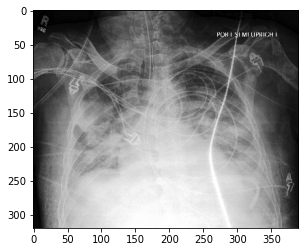

In [14]:
from PIL import Image
fname = dtrain['Path'].iloc[0]
image = Image.open(fname).convert("L")
arr = np.asarray(image)
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.show()

In [15]:
last_conv_layer = model.get_layer('conv2d_7')
print(last_conv_layer)
print(last_conv_layer.output)

ValueError: No such layer: conv2d_7.

In [ ]:
index=0
argmax = np.argmax(pred[index])
print(pred[index])
print(argmax)


output = model.output[:, argmax]
# tf.compat.v1.disable_eager_execution()
grads = K.gradients(output, last_conv_layer.output)[0]
print(grads)
# pooled_grads = K.mean(grads, axis=(0, 1, 2))

# iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# x=valid_generator[index][0]
# pooled_grads_value, conv_layer_output_value = iterate([x])

# for i in range(1024):
#     conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# heatmap = np.mean(conv_layer_output_value, axis=-1)
# heatmap = np.maximum(heatmap, 0)
# heatmap /= np.max(heatmap)
# plt.matshow(heatmap)
# plt.show()



# import cv2
# # select the sample and read the corresponding image and label
# sample_image = cv2.imread(fname)
# # pre-process the image
# sample_image = cv2.resize(sample_image, (224,224))
# if sample_image.shape[2] ==1:
#             sample_image = np.dstack([sample_image, sample_image, sample_image])
# sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
# sample_image = sample_image.astype(np.float32)/255.
# sample_label = 1

# sample_image_processed = np.expand_dims(sample_image, axis=0)
# sample_image_processed.shape
# heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
# heatmap = heatmap *255
# heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
# heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# from skimage import data, color, io, img_as_float
# sample_image_hsv = color.rgb2hsv(sample_image)
# heatmap = color.rgb2hsv(heatmap)

# alpha=0.7
# sample_image_hsv[..., 0] = heatmap[..., 0]
# sample_image_hsv[..., 1] = heatmap[..., 1] * alpha

# img_masked = color.hsv2rgb(sample_image_hsv)
# f,ax = plt.subplots(1,2, figsize=(16,6))
# ax[0].imshow(sample_image)
# ax[0].set_title(f"Image - Lung Opacity Traget")
# ax[0].axis('off')
    
# ax[1].imshow(img_masked)
# ax[1].set_title("Class Activation Map - Lung Opacity has highest predicted probability")
# ax[1].axis('off')

# plt.show()